In [1]:
import os
import io
import numpy as np
import pandas as pd
from scipy import stats

import imageio
from PIL import Image
from IPython import display
from pandas import datetime
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
api_key = <Google Maps API Key> 
# Make sure you delete your API keys before sharing!
# Did_you_get_it = "" # Answer "yes" here
# assert(Did_you_get_it == "yes")

In [3]:
# Bokeh Google Maps
from bokeh.io import output_file, show, output_notebook, save
from bokeh.models import ColumnDataSource, GMapOptions
from bokeh.plotting import gmap
from bokeh.io import export_png
output_notebook()

# Used for hiding bookeh warnings
import warnings
warnings.filterwarnings('ignore')

# Geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim()

# Mapsplotlib
from mapsplotlib import mapsplot as mplt
mplt.register_api_key(api_key)
# Googlemaps
from googlemaps import convert, roads, client

Loading BokehJS ...

In [4]:
beijing = geolocator.geocode("Beijing")

## Preprocessing

In [5]:
df = pd.read_csv("./Data/000/Trajectory/20081023025304.plt", 
                 skiprows=6, usecols=[0,1,5,6], header=None, parse_dates={'date_time':[2,3]}, 
                 infer_datetime_format=True, names=["latitude", "longitude", "x", "altitude", "n_days", "date", "time"])
print("Any NaNs?: ", df.isnull().any().any())
df.drop_duplicates(inplace=True)
df.dropna(inplace=True) # just for sanity
df.head()

Any NaNs?:  False


,date_time,latitude,longitude
0,2008-10-23 02:53:04,39.984702,116.318417
1,2008-10-23 02:53:10,39.984683,116.318450
2,2008-10-23 02:53:15,39.984686,116.318417
3,2008-10-23 02:53:20,39.984688,116.318385
4,2008-10-23 02:53:25,39.984655,116.318263


In [6]:
labels = pd.read_csv("./Data/104/labels.txt", parse_dates=[0,1], infer_datetime_format=True, sep='\t')
labels.head()

,Start Time,End Time,Transportation Mode
0,2007-11-30 09:59:00,2007-11-30 10:38:00,bus
1,2007-11-30 12:40:00,2007-11-30 13:18:00,bus
2,2007-12-02 12:27:00,2007-12-02 12:57:00,bus
3,2007-12-02 13:00:00,2007-12-02 13:25:00,bus
4,2007-12-04 07:45:00,2007-12-04 08:30:00,car


In [7]:
def get_traj_files(dataset_dir):
    traj_file_paths = []
    for path, dir_names, file_names in os.walk(dataset_dir):
        for file_name in file_names:
            if file_name.endswith(".plt"):
                traj_file_paths.append(os.path.join(path, file_name))
    return traj_file_paths

def get_dataframe(traj_file_paths, select_user=None, restrict_lat=None, restrict_long=None):
    data = []
    lat_min, lat_max = -90, 90
    long_min, long_max = 0, 180
    if restrict_lat is not None:
        lat_min, lat_max = restrict_lat
    if restrict_long is not None:
        long_min, long_max = restrict_long
    assert(isinstance(traj_file_paths, list))
    for file_path in traj_file_paths:
        user_id = int(file_path[7:10])
        labels_file = os.path.join(file_path[:10], "labels.txt")
        if select_user is None or user_id in select_user:
            
            df = pd.read_csv(file_path,
                 skiprows=6, usecols=[0,1,5,6], header=None, parse_dates={'date_time':[2,3]}, 
                 infer_datetime_format=True, names=["latitude", "longitude", "x", "altitude", "n_days", "date", "time"])
            df["user_id"] = user_id
            
            if df["longitude"].max() <= long_max and  df["longitude"].min() >= long_min \
                and df["latitude"].max() <= lat_max and df["latitude"].min() >= lat_min:
                
                data.append(df)
    return pd.concat(data, ignore_index=True)

DATASET_DIR = "./Data"
traj_file_paths = get_traj_files(DATASET_DIR)
assert(len(traj_file_paths) == 18670)

In [18]:
data = get_dataframe(traj_file_paths)

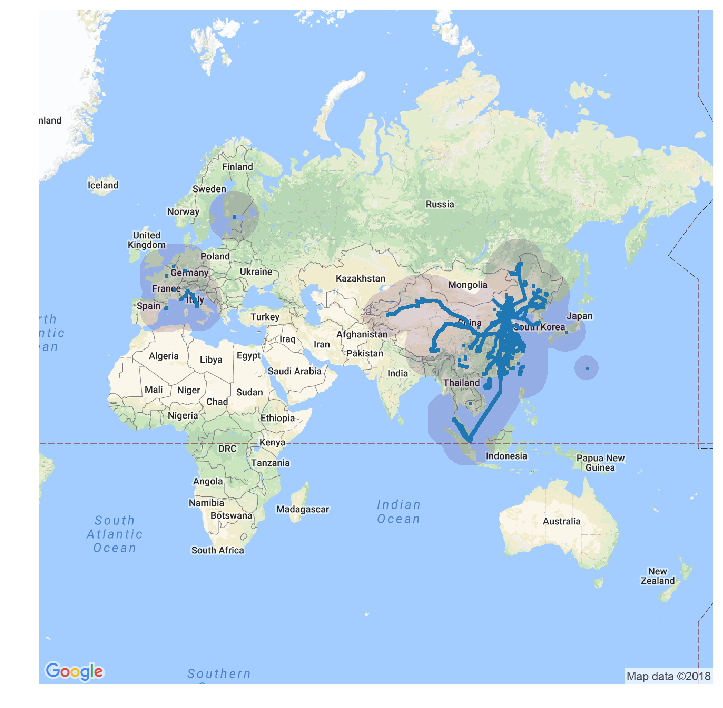

In [19]:
mplt.density_plot(data['latitude'], data['longitude'])

### Filter samples by bbox

To converting miles to longitude/latitude, I'm using a simple approximation from the blog by John D. Cook:
https://www.johndcook.com/blog/2009/04/27/converting-miles-to-degrees-longitude-or-latitude/.

In [8]:
import math

# Distances are measured in miles.
# Longitudes and latitudes are measured in degrees.
# Earth is assumed to be perfectly spherical.

earth_radius = 3960.0
degrees_to_radians = math.pi/180.0
radians_to_degrees = 180.0/math.pi

def change_in_latitude(miles):
    "Given a distance north, return the change in latitude."
    return (miles/earth_radius)*radians_to_degrees

def change_in_longitude(latitude, miles):
    "Given a latitude and a distance west, return the change in longitude."
    # Find the radius of a circle around the earth at given latitude.
    r = earth_radius*math.cos(latitude*degrees_to_radians)
    return (miles/r)*radians_to_degrees

def get_bbox(location=(0, 0), ns_miles=2, ew_miles=2):
    
    lat, long = location
    lat_diff = change_in_latitude(ns_miles) / 2.
    long_diff = change_in_longitude(lat, ew_miles) / 2.
    return lat - lat_diff, lat + lat_diff, long - long_diff, long + long_diff

lat_min, lat_max, long_min, long_max = get_bbox((beijing.latitude, beijing.longitude), 30, 30)
lat_min, lat_max, long_min, long_max

(39.68893363214742, 40.122992567852585, 116.10832540342525, 116.67417059657475)

In [10]:
data = get_dataframe(traj_file_paths[:10000], restrict_lat=(lat_min, lat_max), restrict_long=(long_min, long_max))

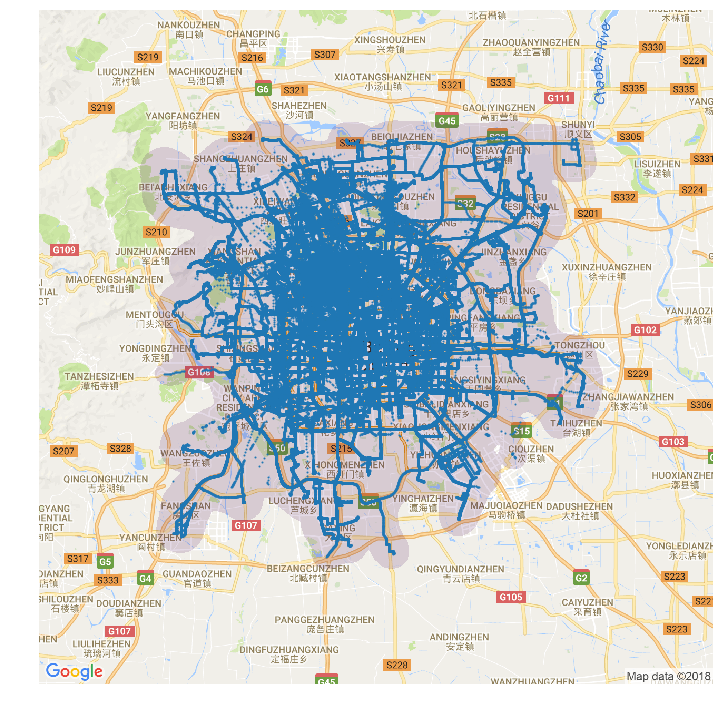

In [11]:
mplt.density_plot(data['latitude'], data['longitude'])

## Analyze a trip

In [9]:
def show_img(filename):
    plt.figure(figsize=(12,12))
    plt.imshow(plt.imread(filename))
    plt.axis('off')

In [10]:
data = get_dataframe(traj_file_paths, select_user=[1], restrict_lat=(lat_min, lat_max), restrict_long=(long_min, long_max))
df1 = data
df1 = df1.sort_values(by="date_time")
# Take a short segment
df1 = df1[:200]

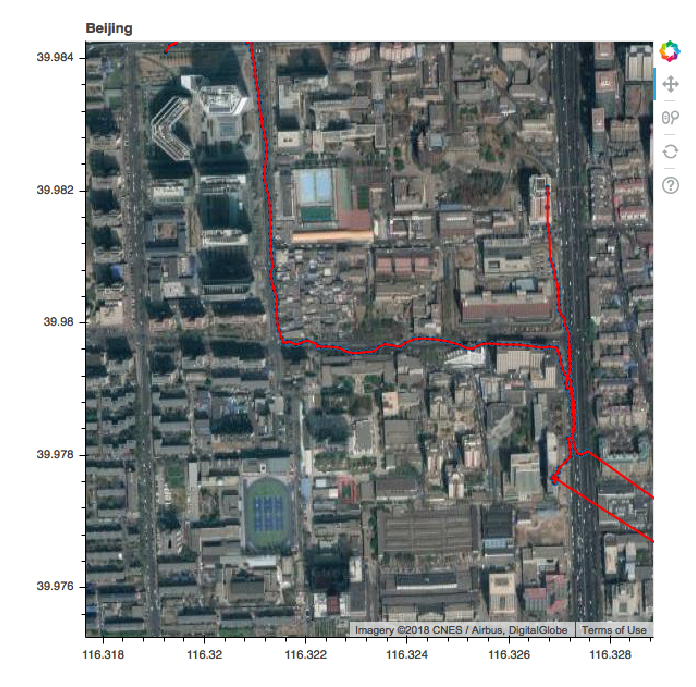

In [11]:
from bokeh.io import export_png
map_options = GMapOptions(lat=df1.latitude.median(), lng=df1.longitude.median(), map_type="satellite", zoom=16)
p = gmap(api_key, map_options, title="Beijing")
source = ColumnDataSource(
    data=dict(lat=df1['latitude'],
              lon=df1["longitude"])
)
p.circle(x="lon", y="lat", size=5, fill_color="black", fill_alpha=0.7, source=source)
p.line(x="lon", y="lat", line_width=2, line_color="red", source=source)
#show(p)
export_png(p, filename="./plot.png")
show_img("./plot.png")

# Kalman Smoothing

In [12]:
from pykalman import KalmanFilter
measurements = np.asarray([df1.latitude, df1.longitude])
measurements = measurements.T[:]
kf = KalmanFilter(initial_state_mean = measurements[0], \
           n_dim_obs=2, n_dim_state=2)
kf = kf.em(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

In [13]:
df1["smooth_latitude"] = smoothed_state_means[:,0]
df1["smooth_longitude"] = smoothed_state_means[:,1]

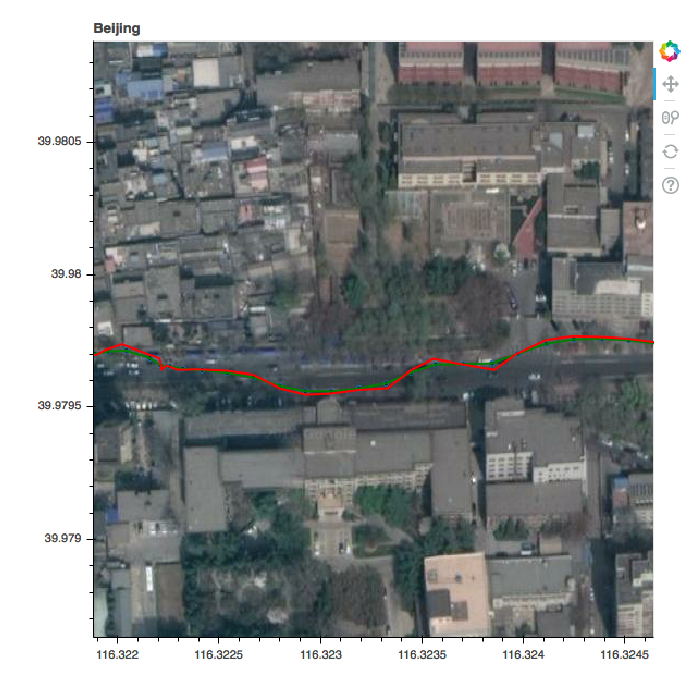

In [14]:
map_options = GMapOptions(lat=df1.latitude.median(), lng=df1.longitude.median(), map_type="satellite", zoom=18)
p = gmap(api_key, map_options, title="Beijing")
source_smooth = ColumnDataSource(
    data=dict(lat=df1['smooth_latitude'],
              lon=df1["smooth_longitude"])
)
p.circle(x="lon", y="lat", size=5, fill_color="black", fill_alpha=0.7, source=source_smooth)
p.line(x="lon", y="lat", line_width=2, line_color="green", source=source_smooth)
p.line(x="lon", y="lat", line_width=2, line_color="red", source=source)
# show(p)
export_png(p, filename="./plot.png")
show_img("./plot.png")

KF helps in smoothing the path. But in some cases, such as the one shown below, where GPS has possibly reported an erroneous reading that's way out of it's mean, it can't help because it's unpredictable.

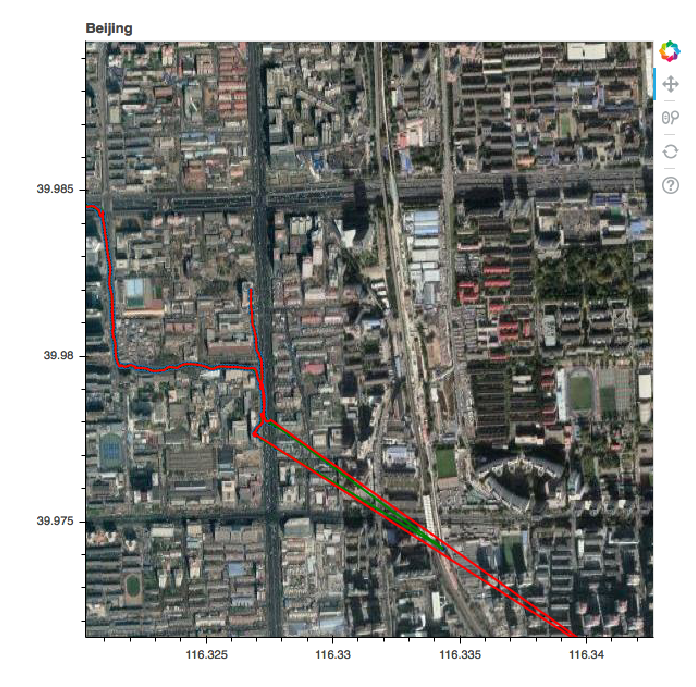

In [15]:
map_options = GMapOptions(lat=df1.latitude.min()+0.01, lng=df1.longitude.max()-0.01, map_type="satellite", zoom=15)
p = gmap(api_key, map_options, title="Beijing")
source = ColumnDataSource(
    data=dict(lat=df1['latitude'],
              lon=df1["longitude"])
)
source_smooth = ColumnDataSource(
    data=dict(lat=df1['smooth_latitude'],
              lon=df1["smooth_longitude"])
)
p.circle(x="lon", y="lat", size=5, fill_color="black", fill_alpha=0.7, source=source_smooth)
p.line(x="lon", y="lat", line_width=2, line_color="green", source=source_smooth)
p.line(x="lon", y="lat", line_width=2, line_color="red", source=source)
# show(p)
export_png(p, filename="./plot.png")
show_img("./plot.png")

Need a better way to filter samples with such erratic speed changes.

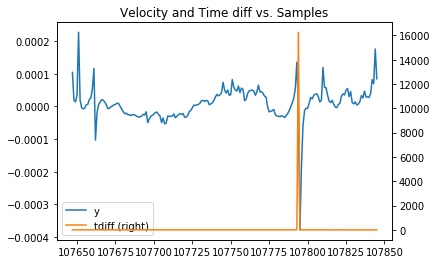

In [16]:
df1["tdiff"] = df1["date_time"].diff() / np.timedelta64(1,'s')
df1["displacement"] = df1["smooth_latitude"].diff() + df1["smooth_longitude"].diff()
df1["velocity"] = df1["displacement"] / df1["tdiff"]
ax = df1.plot(y="velocity", label="y", title="Velocity and Time diff vs. Samples")
df1.plot(y="tdiff", ax=ax, secondary_y=True)

It's interesting note that between the endpoints of erratic change, 16000 seconds (4.44 hours) has passed. That explains a lot, maybe the person had switched off the GPS tracker and when turned back on it initially reported readings that were far off, or we have some missing samples and person actually visited that place in the lower right corner.

# Google Snap to Roads

In [17]:
gmaps = client.Client(key=api_key)
# Google API has a restriction on number of points we can snap in a request
# ApiError: INVALID_ARGUMENT ("path" contains too many points. The maximum number of points is 100.)
df1 = df1[:100]
df1 = df1.reset_index(drop=True)
_path = [(p['latitude'],p['longitude']) for i, p in df1[:100].iterrows()]
snapped_path = roads.snap_to_roads(gmaps, _path, False)

In [18]:
snapped_path[:5]

[{'location': {'latitude': 39.984337, 'longitude': 116.3201383},
  'originalIndex': 5,
  'placeId': 'ChIJaVdlYVRR8DURqwRer1UHlI8'},
 {'location': {'latitude': 39.984337, 'longitude': 116.3201383},
  'originalIndex': 6,
  'placeId': 'ChIJaVdlYVRR8DURqwRer1UHlI8'},
 {'location': {'latitude': 39.984337, 'longitude': 116.3201383},
  'originalIndex': 7,
  'placeId': 'ChIJaVdlYVRR8DURqwRer1UHlI8'},
 {'location': {'latitude': 39.984337, 'longitude': 116.3201383},
  'originalIndex': 8,
  'placeId': 'ChIJaVdlYVRR8DURqwRer1UHlI8'},
 {'location': {'latitude': 39.984337, 'longitude': 116.3201383},
  'originalIndex': 9,
  'placeId': 'ChIJaVdlYVRR8DURqwRer1UHlI8'}]

In [19]:
df1["snapped_latitude"] = np.nan
df1["snapped_longitude"] = np.nan
for sp in snapped_path:
    df1.at[sp['originalIndex'], "snapped_latitude"] = sp['location']['latitude']
    df1.at[sp['originalIndex'], "snapped_longitude"] = sp['location']['longitude']

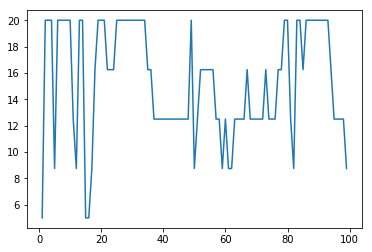

In [20]:
def normalize(x, to_min=0., to_max=1.):
    norm_0_1 = (x - x.min()) / (x.max() - x.min())
    return to_min + (to_max-to_min) * norm_0_1
# To show time diff on the map
df1["tdiff_clipped"] = np.minimum(df1["tdiff"], 2*stats.mode(df1["tdiff"]).mode[0]) # visualization hack
df1["tdiff_normalized"] = normalize(df1["tdiff_clipped"], 5, 20) # another hack
df1["tdiff_normalized"].plot()

In [21]:
df1["snapped_latitude"] = df1["snapped_latitude"].interpolate(method="linear").bfill()
df1["snapped_longitude"] = df1["snapped_longitude"].interpolate(method="linear").bfill()

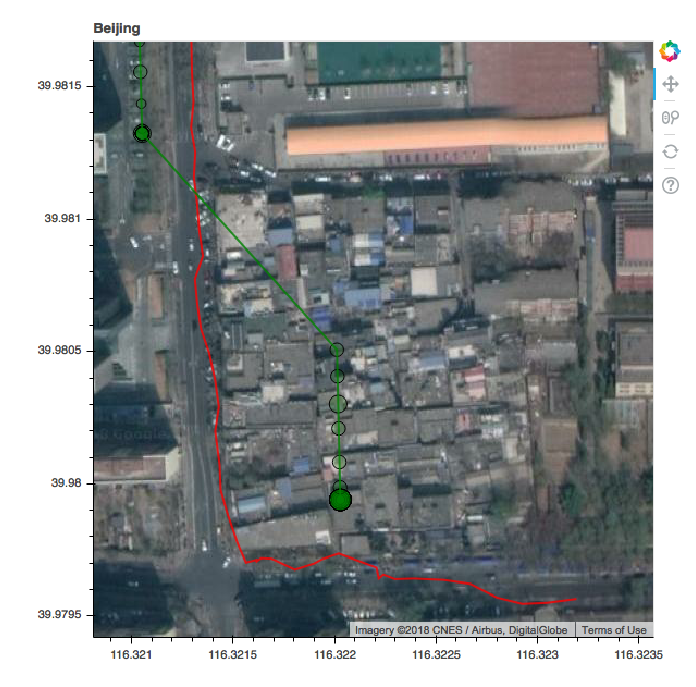

In [22]:
map_options = GMapOptions(lat=df1.latitude.min()+0.001, lng=df1.longitude.max()-0.001, map_type="satellite", zoom=18)
p = gmap(api_key, map_options, title="Beijing")
source = ColumnDataSource(
    data=dict(lat=df1['latitude'],
              lon=df1["longitude"],
              tdiff=df1["tdiff_normalized"])
)
snapped_source = ColumnDataSource(
    data=dict(lat=df1['snapped_latitude'],
              lon=df1['snapped_longitude'],
             tdiff=df1["tdiff_normalized"])
)
# p.circle(x="lon", y="lat", size='tdiff', line_color="black", fill_alpha=0.2, source=source)
p.line(x="lon", y="lat", line_width=2, line_color="red",line_alpha=0.8, source=source)
p.circle(x="lon", y="lat", size='tdiff', line_color="black", fill_color="green", fill_alpha=0.2, source=snapped_source)
p.line(x="lon", y="lat", line_width=2, line_color="green",  line_alpha=0.8, source=snapped_source)
# show(p)
export_png(p, filename="./plot.png")
show_img("./plot.png")

Not very useful here, as we can see it's not snapped to the road but goes over the buildings. What could have gone wrong?

Plotting the road or terrain map reveals that it's likely because of the discrepency in google's standard map vs. the actual map of the city when the data was sampled as well as satellite imagery.

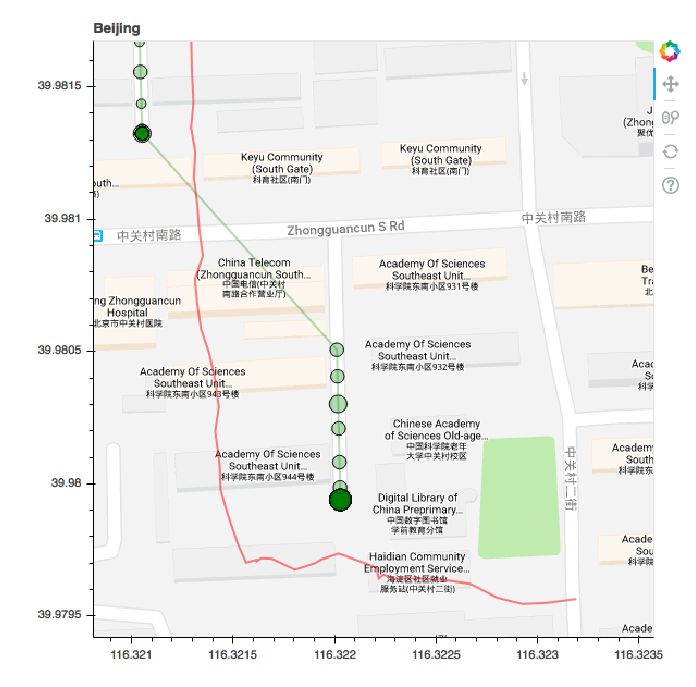

In [23]:
map_options = GMapOptions(lat=df1.latitude.min()+0.001, lng=df1.longitude.max()-0.001, map_type="roadmap", zoom=18)
p = gmap(api_key, map_options, title="Beijing")
# p.circle(x="lon", y="lat", size='tdiff', fill_color="black", fill_alpha=0.5, source=source)
p.line(x="lon", y="lat", line_width=2, line_color="red",line_alpha=0.5, source=source)
p.circle(x="lon", y="lat", size='tdiff', line_color="black", fill_color="green", fill_alpha=0.3, source=snapped_source)
p.line(x="lon", y="lat", line_width=2, line_color="green",  line_alpha=0.3, source=snapped_source)
# show(p)
export_png(p, filename="./plot.png")
show_img("./plot.png")